# Toy OSC

Goal: Show possible issues with null-space and feedback control.

Two-dof prismatic setup kinda like example shown in [PS 2006]

```
 |->   |->  |
 q₀    q₁   x
```

with the following:

$$
\begin{align*}
    x &= q_0 + q_1 \\
    J &= \begin{bmatrix} 1 & 1 \end{bmatrix}
\end{align*}
$$

## Refs

* [PS 2006] Peters, Jan, and Stefan Schaal. “Learning Operational Space Control,” 2006. https://doi.org/10.15607/RSS.2006.II.033.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
J = np.array([[1, 1]])

In [3]:
# These null-spaces are effectively unused, but just show some basic properties.
Jpinv = np.linalg.pinv(J)
N = np.eye(2) - Jpinv @ J
print(Jpinv)
print(N)
# Compute some other null spaces - they're just reductions of the above
# (I think?).
N2 = scipy.linalg.null_space(J)
U, s, V_T = np.linalg.svd(J)
N3 = V_T[:, -1:]
print(N2)
print(N3)

[[0.5]
 [0.5]]
[[ 0.5 -0.5]
 [-0.5  0.5]]
[[-0.70710678]
 [ 0.70710678]]
[[-0.70710678]
 [ 0.70710678]]


In [4]:
M = np.eye(2)
# M = np.diag([1.0, 3.0])
# M = np.array([
#     [1.0, 0.01],
#     [0.01, 0.1],
# ])
Minv = np.linalg.inv(M)
Mtinv = J @ Minv @ J.T
Mt = np.linalg.inv(Mtinv)
# Same as nominal null-space.
Jbar = Minv @ J.T @ Mt  # Jpinv, dynamic
Nt = np.eye(2) - Jbar @ J
Nt_T = Nt.T

print(Jbar)
print(Nt)

[[0.5]
 [0.5]]
[[ 0.5 -0.5]
 [-0.5  0.5]]


In [5]:
def naive_euler(q, v, vd_func, tf, dt):
    t = 0.0
    ts = []
    qs = []
    q = q.copy()
    v = v.copy()
    eps = 1e-8
    while t <= tf + eps:
        qs.append(q)
        ts.append(t)
        vd = vd_func(q, v)
        q = q + v * dt
        v = v + vd * dt
        t += dt
    ts, qs = map(np.asarray, (ts, qs))
    return ts, qs

In [6]:
q_nominal = np.array([0.0, 2.0])

def calc_vd(q, v):
    x = q[0] + q[1]
    x_des = 3.0
    e_t = x - x_des
    ed_t = J @ v
    kp_t = 1.0
    kd_t = 2.0 * np.sqrt(kp_t)
    edd_t_c = -kp_t * e_t - kd_t * ed_t

    e_p = q - q_nominal
    ed_p = v
    kp_p = 2.0
    kd_p = 2.0 * np.sqrt(kp_p)
    edd_p_c = -kp_p * e_p - kd_p * ed_p

    tau = J.T @ Mt @ edd_t_c + Nt_T @ M @ edd_p_c
    vd = Minv @ tau
    return vd

In [7]:
def reset_color_cycle():
    # https://stackoverflow.com/a/39116381/7829525
    plt.gca().set_prop_cycle(None)

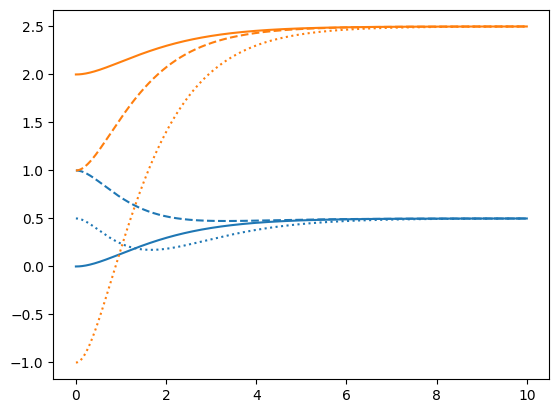

In [8]:
q0s = np.array(
    [
        q_nominal,
        # q_nominal + [0.1, -0.1],
        q_nominal + [1.0, -1.0],
        # Non-minimum phase.
        q_nominal + [0.5, -3.0],
    ],
)
styles = ["-", "--", ":", "-."]
v0 = np.array([0.0, 0.0])

for q0, style in zip(q0s, styles):
    ts, qs = naive_euler(q0, v0, calc_vd, tf=10.0, dt=0.01)
    plt.plot(ts, qs, linestyle=style)
    reset_color_cycle()